In [2]:
#importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow
%matplotlib inline

In [4]:
#Importing and reading the data
data = np.load('E:\mrinal\python\CV Project\images.npy',allow_pickle=True)

In [5]:
#Defing image height and width
image_width = 224
image_height = 224

In [6]:
#Split the data into x and y
from tensorflow.keras.applications.mobilenet import preprocess_input
x = np.zeros((int(data.shape[0]), image_height, image_width,3))
y = np.zeros((int(data.shape[0]), image_height, image_width))

for i in range(data.shape[0]):
    img = data[i][0]
    image = cv2.resize(img,dsize = (image_height,image_width),interpolation=cv2.INTER_CUBIC)
    try:
        image = image[:, :, :3]
    except:
        continue
    x[i] = preprocess_input(np.array(image, dtype=np.float32))
    for r in data[i][1]:
        x1 = int(r['points'][0]['x']*image_width)
        x2 = int(r['points'][1]['x']*image_width)
        y1 = int(r['points'][0]['y']*image_height)
        y2 = int(r['points'][1]['y']*image_height)
        ##r = cv2.resize(r, (28,28))
        #y[i][y1:y2,x1:x2] = 1
        #y = cv2.resize(r, (28,28))
        #y[i,:,:] = np.squeeze(r)
        y[i][y1:y2,x1:x2] = 1
#y = np.reshape(y, (409, 28,28))

In [7]:
#Splitting the data into [400:9] ratio
x_train = x[:400]
x_test = x[400:]
y_train = y[:400]
y_test = y[400:]

In [8]:
y_train.shape

(400, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


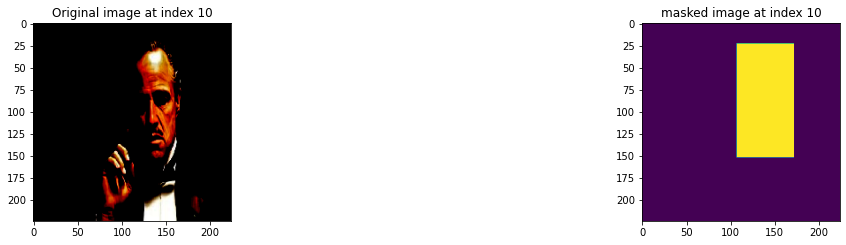

In [9]:
#Printing the random image from training data and displaying original and mask image
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.title(f"Original image at index {10}")
plt.imshow(x_train[10])
plt.subplot(2,2,2)
plt.title(f"masked image at index {10}")
plt.imshow(y_train[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


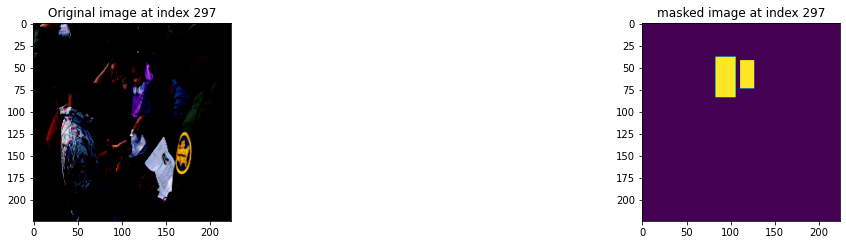

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.title(f"Original image at index {297}")
plt.imshow(x_train[297])
plt.subplot(2,2,2)
plt.title(f"masked image at index {297}")
plt.imshow(y_train[297])

Create the Model

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

In [12]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(image_height, image_width, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block0 = model.layers[0].input
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_2_relu").output
    block3 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block13), block11])
    x = Concatenate()([UpSampling2D()(x), block5])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((image_height, image_width))(x)

    return Model(inputs=model.input, outputs=x) 

Defining the Dice Coefficiene

In [13]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

Defing the loss function

In [14]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [15]:
#Creating the model and printing the summary
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

                                                                                                  
Total params: 3230852 (12.32 MB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 3228864 (12.32 MB)
__________________________________________________________________________________________________


Compile the model

In [18]:
optimizer = tensorflow.keras.optimizers.legacy.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

C:\Anaconda\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Defining callbacks

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1,mode='min', save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5, mode='min')

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode='min')

Fit the model

In [20]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=5, verbose=1, callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 2.4878 - dice_coefficient: 0.1720
Epoch 1: val_loss improved from inf to 2.15572, saving model to model-2.16.h5
64/64 [==============================] - 324s 5s/step - loss: 2.4878 - dice_coefficient: 0.1720 - val_loss: 2.1557 - val_dice_coefficient: 0.2189 - lr: 1.0000e-04
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 1.9335 - dice_coefficient: 0.2511
Epoch 2: val_loss improved from 2.15572 to 1.70708, saving model to model-1.71.h5
64/64 [==============================] - 313s 5s/step - loss: 1.9335 - dice_coefficient: 0.2511 - val_loss: 1.7071 - val_dice_coefficient: 0.2919 - lr: 1.0000e-04
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 1.5459 - dice_coefficient: 0.3246
Epoch 3: val_loss improved from 1.70708 to 1.42351, saving model to model-1.42.h5
64/64 [==============================] - 265s 4s/step - loss: 1.5459 - dice_coefficient: 0.3246 - val_loss: 1.4235 - val_dice_

In [21]:
#Saving the model
model.save('model.h5')

C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


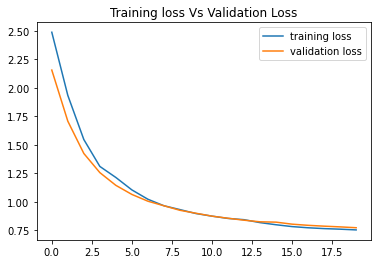

In [22]:
#plotting loss and val_loss against epochs
plt.plot(history.epoch,history.history['loss'],label='training loss')
plt.plot(history.epoch,history.history['val_loss'],label= 'validation loss')
plt.title('Training loss Vs Validation Loss')
plt.legend()
plt.show()

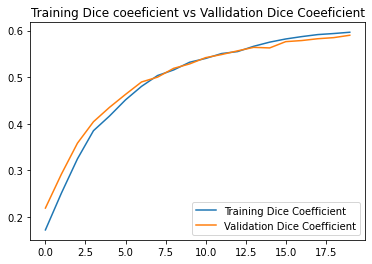

In [23]:
#plotting dice_coefficient and val_dice_coefficient against epochs
plt.plot(history.epoch,history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.epoch,history.history['val_dice_coefficient'], label="Validation Dice Coefficient")
plt.title('Training Dice coeeficient vs Vallidation Dice Coeeficient')
plt.legend()
plt.show()

* We got validation dice coefficient of 0.6282, which indicates that the performance of the model is good. However model performs poorly when we gave batch_size of 32. So Changed it to 5.
* Also from loss and val_loss graph we can see that the performs well in both training and validation set.
* Dice coefficient is also increases as the no of epoch increases for both training and validation set.

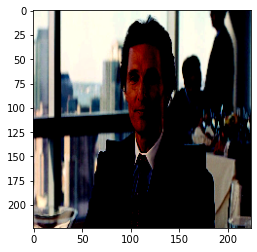

In [24]:
plt.imshow(x_test[3])

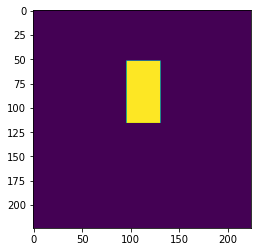

In [25]:
plt.imshow(y_test[3])

In [26]:
#loading the model
mod = tensorflow.keras.models.load_model('model.h5',compile=False)

In [27]:
#Prediction for test image at index 3
pred_3= mod.predict(np.expand_dims(x_test[3],axis=0))

1/1 [==============================] - 5s 5s/step


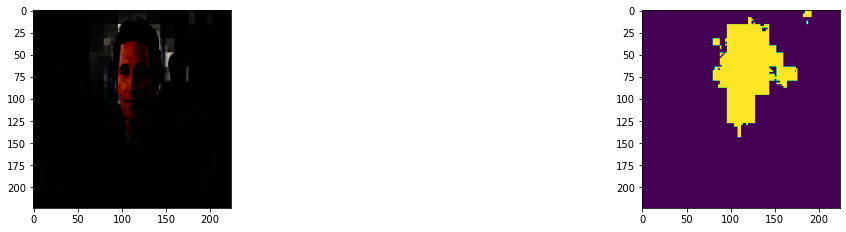

In [32]:
#Plottting the original and mask image
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.imshow(x_test[3])
plt.subplot(2,2,2)
plt.imshow(pred_3[0]>0.2)

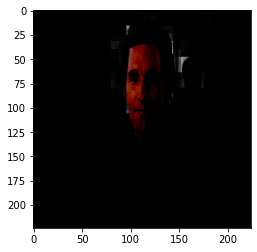

In [33]:
img2 = x_test[3]
img2[:,:,0] = pred_3[0] * x_test[3][:,:,0]
img2[:,:,1] = pred_3[0] * x_test[3][:,:,1]
img2[:,:,2] = pred_3[0] * x_test[3][:,:,2]

plt.imshow(img2)